In [1]:
import torch
import torch.nn as nn


class model_transformer(nn.Module):
    def __init__(self, input_dim, seq_len, embedding_dim, num_head, num_layers, forward_dim, dropout):
        super().__init__()
        self.embedding = nn.Linear(input_dim, embedding_dim)
        self.pos_embedding = nn.Parameter(
            torch.randn(1, seq_len, embedding_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, nhead=num_head, dim_feedforward=forward_dim, dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Linear(embedding_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = x + self.pos_embedding

        x = self.encoder(x)

        x = x.transpose(1, 2)
        x = self.pool(x)
        x = x.squeeze(2)
        x = self.linear(x)

        return x

In [2]:
# === 0. Environment Setup ===
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error

# sklearn models
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# TensorFlow/Keras models
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping

# PyTorch Transformer model & training tools
import torch
from torch.utils.data import DataLoader, TensorDataset
# from model_transformer import model_transformer  # from the attached model_transformer.py

# Paths and constants
TRAIN_CSV    = '/kaggle/input/LANL-Earthquake-Prediction/train.csv'
SEGMENT_SIZE = 150_000
TEST_SIZE    = 0.2
RANDOM_SEED  = 42

# === 1. Helper functions: Hurst Exponent & Fractal Dimension & Crest Factor & Rise Time ===
def hurst_exponent(ts):
    lags = range(2, 100)
    tau  = [np.sqrt(np.std(ts[lag:] - ts[:-lag])) for lag in lags]
    m    = np.polyfit(np.log(lags), np.log(tau), 1)
    return m[0]

def fractal_dimension(x, kmax=10):
    N, L = len(x), []
    for k in range(1, kmax):
        Lk = []
        for m in range(k):
            idx = np.arange(m, N, k)
            y   = x[idx]
            if len(y) < 2: continue
            Lk.append((np.sum(np.abs(np.diff(y))) * (N-1)) / ((len(y)-1)*k))
        if Lk: L.append(np.mean(Lk))
    if len(L) < 2: return np.nan
    coeffs = np.polyfit(np.log(1.0/np.arange(1, len(L)+1)), np.log(L), 1)
    return coeffs[0]

# === 2. Feature extraction function ===
def extract_features_segment(x_raw):
    x = x_raw.astype(np.float32)
    f = {}
    # Basic statistics
    f['mean'], f['std']    = x.mean(), x.std()
    f['min'], f['max']     = x.min(), x.max()
    f['range'], f['median']= x.max()-x.min(), np.median(x)
    # Quantiles & IQR
    for q in [1,5,10,25,75,90,95,99]:
        f[f'q{q:02d}'] = np.percentile(x, q)
    f['iqr'] = f['q75'] - f['q25']
    # Distribution shape
    f['skewness'], f['kurtosis'] = skew(x), kurtosis(x)
    # Other statistics
    f['mad']    = np.mean(np.abs(x - f['mean']))
    f['rms']    = np.sqrt(np.mean(x**2))
    f['energy'] = np.sum(x**2) / SEGMENT_SIZE
    f['zcr']    = ((x[:-1]*x[1:])<0).sum() / SEGMENT_SIZE
    # Signal features
    f['fractal_dimension'] = fractal_dimension(x)
    f['hurst_exponent']    = hurst_exponent(x)
    f['crest_factor']      = np.max(np.abs(x)) / (f['rms'] + 1e-10)
    f['rise_time']         = abs(np.argmax(x) - np.argmin(x)) / float(SEGMENT_SIZE)
    return f

# === 3. Read in segments & feature extraction ===
reader = pd.read_csv(
    TRAIN_CSV,
    usecols=['acoustic_data','time_to_failure'],
    dtype={'acoustic_data':np.int16,'time_to_failure':np.float32},
    chunksize=SEGMENT_SIZE
)

feature_dicts, targets = [], []
for chunk in tqdm(reader):
    feature_dicts.append(extract_features_segment(chunk['acoustic_data'].values))
    targets.append(chunk['time_to_failure'].values[-1])

df_feat = pd.DataFrame(feature_dicts)
y       = np.array(targets)
X       = df_feat.values
feature_names = df_feat.columns.tolist()

# === 4. Split train/test sets ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED
)
n_features = X_train.shape[1]

# === 5. Permutation Importance function ===
def permutation_importance(model, X_val, y_val, metric):
    """Return permutation importance for each feature = permuted_metric - baseline_metric"""
    baseline = metric(y_val, model.predict(X_val))
    imps = []
    for i in range(n_features):
        X_perm = X_val.copy()
        np.random.shuffle(X_perm[:, i])
        perm_score = metric(y_val, model.predict(X_perm))
        imps.append(perm_score - baseline)
    return np.array(imps)

# === 6. Random Forest: Permutation ===
rf = RandomForestRegressor(
    n_estimators=100, max_depth=10, n_jobs=-1, random_state=RANDOM_SEED
)
rf.fit(X_train, y_train)
rf_perm = permutation_importance(rf, X_test, y_test, mean_absolute_error)

# === 7. MLP Regressor: Permutation ===
mlp = MLPRegressor(
    hidden_layer_sizes=(100,50), max_iter=1000,
    random_state=RANDOM_SEED
)
mlp.fit(X_train, y_train)
mlp_perm = permutation_importance(mlp, X_test, y_test, mean_absolute_error)

# === 8. LSTM: Permutation ===
X_tr_l, X_te_l = X_train.reshape(-1,n_features,1), X_test.reshape(-1,n_features,1)
tf.random.set_seed(RANDOM_SEED)
lstm = Sequential([
    LSTM(50, input_shape=(n_features,1)),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mae')
lstm.fit(
    X_tr_l, y_train,
    epochs=20, batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=0
)
class LSTMWrapper:
    def __init__(self, model): self.model = model
    def predict(self, X): return self.model.predict(X.reshape(-1,n_features,1)).flatten()

lstm_wrap = LSTMWrapper(lstm)
lstm_perm = permutation_importance(lstm_wrap, X_test, y_test, mean_absolute_error)

# === 9. TCN: Permutation ===
def build_tcn(input_shape):
    inp = Input(shape=input_shape)
    x   = Conv1D(32, 2, dilation_rate=1, activation='relu', padding='causal')(inp)
    x   = Conv1D(32, 2, dilation_rate=2, activation='relu', padding='causal')(x)
    x   = GlobalAveragePooling1D()(x)
    out = Dense(1)(x)
    return Model(inp, out)

tcn = build_tcn((n_features,1))
tcn.compile(optimizer='adam', loss='mae')
tcn.fit(
    X_tr_l, y_train,
    epochs=20, batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=0
)
tcn_wrap = LSTMWrapper(tcn)
tcn_perm = permutation_importance(tcn_wrap, X_test, y_test, mean_absolute_error)

# reshape data consistent with LSTM/TCN
X_tr_tf, X_te_tf = X_train.reshape(-1,n_features,1), X_test.reshape(-1,n_features,1)
torch.manual_seed(RANDOM_SEED)

# === 10. Transformer: Permutation ===
# Initialize Transformer model
transformer = model_transformer(
    input_dim=1,
    seq_len=n_features,
    embedding_dim=64,
    num_head=4,
    num_layers=2,
    forward_dim=128,
    dropout=0.1
)
optimizer = torch.optim.Adam(transformer.parameters(), lr=1e-3)
loss_fn = torch.nn.L1Loss()

# Construct DataLoader
train_ds = TensorDataset(torch.from_numpy(X_tr_tf).float(),
                         torch.from_numpy(y_train).float())
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

# Train Transformer
transformer.train()
for epoch in range(10):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = transformer(X_batch).squeeze()
        loss = loss_fn(preds, y_batch)
        loss.backward()
        optimizer.step()

# Wrapper to support predict interface
class TransformerWrapper:
    def __init__(self, model): self.model = model
    def predict(self, X):
        X_t = torch.from_numpy(X.reshape(-1,n_features,1)).float()
        self.model.eval()
        with torch.no_grad():
            out = self.model(X_t).cpu().numpy().flatten()
        return out

transformer_wrap = TransformerWrapper(transformer)
transformer_perm = permutation_importance(transformer_wrap, X_test, y_test, mean_absolute_error)

2025-05-03 00:10:00.305959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746231000.497645      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746231000.555307      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
4195it [08:16,  8.45it/s]
I0000 00:00:1746231510.071385      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2

I0000 00:00:1746231520.765232     250 service.cc:148] XLA service 0x7aad140315a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746231520.765756     250 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746231522.070715     250 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


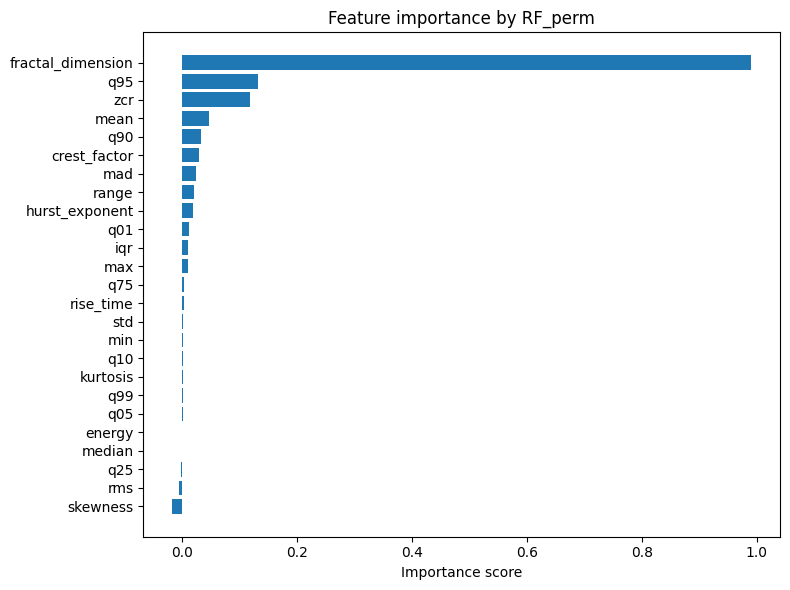

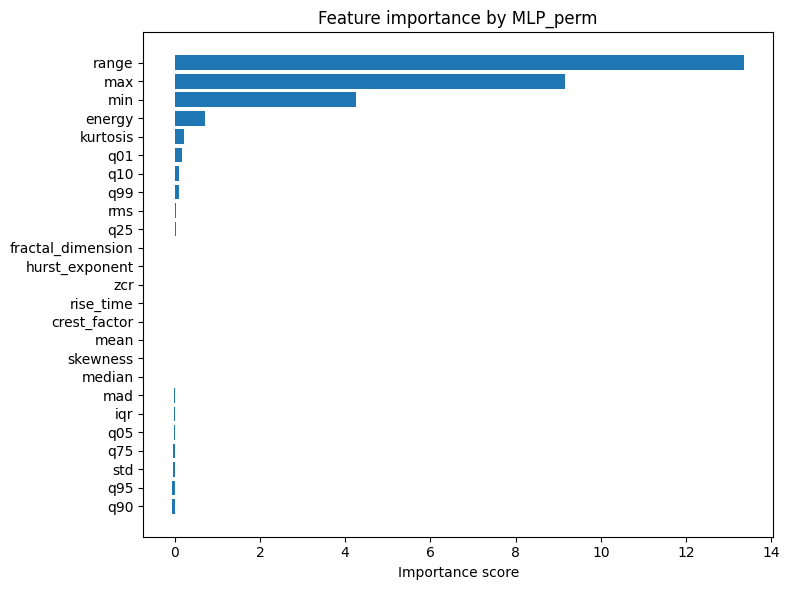

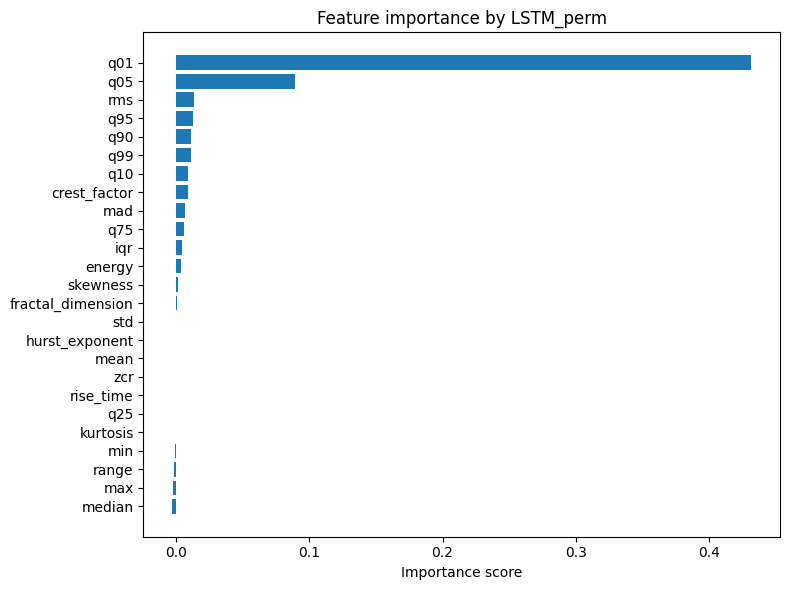

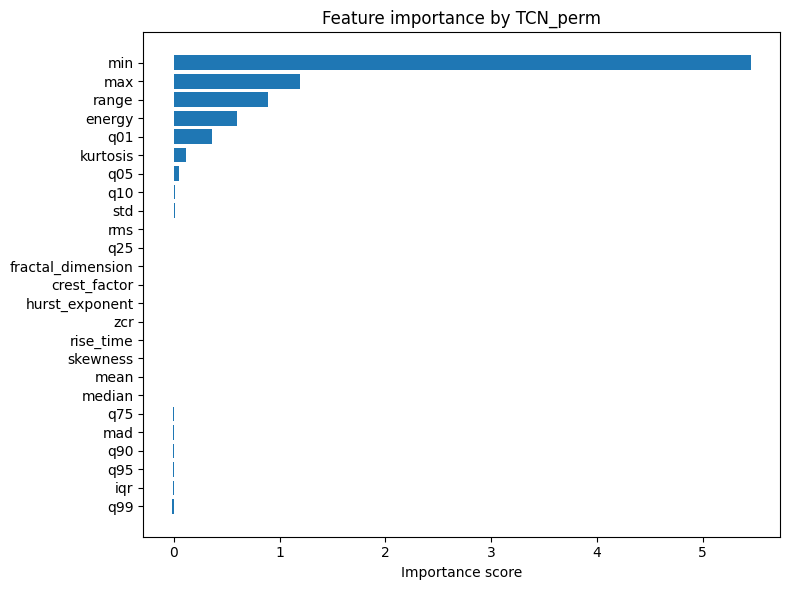

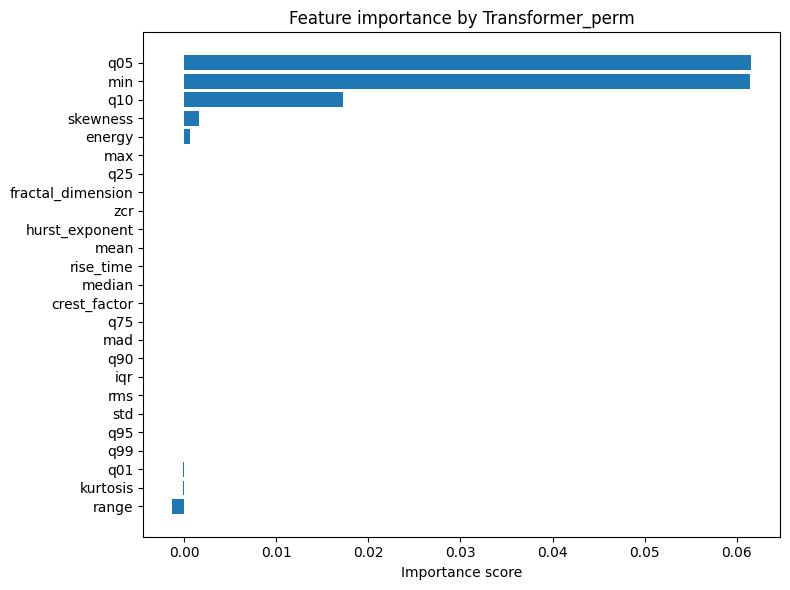


=== Random Forest Feature Importance Ranking ===

| Feature           |   Importance |
|-------------------|--------------|
| fractal_dimension |       0.9905 |
| q95               |       0.1323 |
| zcr               |       0.1181 |
| mean              |       0.0461 |
| q90               |       0.0322 |
| crest_factor      |       0.0294 |
| mad               |       0.0246 |
| range             |       0.0201 |
| hurst_exponent    |       0.0196 |
| q01               |       0.0120 |
| iqr               |       0.0108 |
| max               |       0.0107 |
| q75               |       0.0038 |
| rise_time         |       0.0033 |
| std               |       0.0020 |
| min               |       0.0019 |
| q10               |       0.0016 |
| kurtosis          |       0.0016 |
| q99               |       0.0007 |
| q05               |       0.0006 |
| energy            |       0.0004 |
| median            |       0.0003 |
| q25               |      -0.0013 |
| rms               |   

In [3]:
# === 11. Results aggregation & visualization ===
results = pd.DataFrame({
    'feature':        feature_names,
    'RF_perm':        rf_perm,
    'MLP_perm':       mlp_perm,
    'LSTM_perm':      lstm_perm,
    'TCN_perm':       tcn_perm,
    'Transformer_perm': transformer_perm
})

for col in ['RF_perm','MLP_perm','LSTM_perm','TCN_perm','Transformer_perm']:
    df = results.sort_values(col, ascending=False).reset_index(drop=True)
    plt.figure(figsize=(8,6))
    plt.barh(df['feature'], df[col])
    plt.title(f'Feature importance by {col}')
    plt.xlabel('Importance score')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
# === 12. Output feature importance rankings per model ===
from tabulate import tabulate

# Define the model column names to output and their corresponding titles
model_cols = {
    'RF_perm':        'Random Forest',
    'MLP_perm':       'MLP Regressor',
    'LSTM_perm':      'LSTM',
    'TCN_perm':       'TCN',
    'Transformer_perm': 'Transformer'
}

for col, title in model_cols.items():
    # Sort by importance in descending order
    df_sorted = results[['feature', col]] \
        .sort_values(col, ascending=False) \
        .reset_index(drop=True)

    print(f"\n=== {title} Feature Importance Ranking ===\n")
    print(tabulate(
        df_sorted,
        headers=['Feature', 'Importance'],
        tablefmt='github',
        showindex=False,
        floatfmt=".4f"
    ))